<a href="https://colab.research.google.com/github/Haoyanz/Project-in-AI/blob/master/DistractedDriver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from glob import glob
import cv2

%matplotlib inline

Using TensorFlow backend.


Load Dataset

In [0]:
!unzip '/content/drive/My Drive/state-farm-distracted-driver-detection.zip'

In [2]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
        '/content/imgs/train',
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical', subset="training", color_mode='rgb')

val_generator = val_datagen.flow_from_directory(
        '/content/imgs/train',
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical', subset="validation",  color_mode='rgb')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


Pytorch Implementation of VGG16 Model

In [0]:
VGG16 = [64,64,"M",128,128,"M",256,256,256,"M",512,512,512,"M",512,512,512,"M"]

In [0]:
class VGG_net(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(VGG_net, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG16)

        self.fcs = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1),
                    ),
                    nn.BatchNorm2d(x),
                    nn.ReLU(),
                ]
                in_channels = x
            elif x == "M":
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

        return nn.Sequential(*layers)

Fine-tune VGG16 Model

In [3]:
# take the fine-tune VGG16 Model
vgg16_model = keras.applications.vgg16.VGG16()
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
# initialize our own sequential model
model = Sequential()

# copy every layer except the predictions layer
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

# make weights fixed since these layers are already fine-tuned
for layer in model.layers:
  layer.trainable = False

# add our own layer
model.add(Dense(10, activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

Train the VGG16 Model

In [0]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = 17943//64,
                              validation_data = val_generator,
                              validation_steps = 4481//64,
                              epochs = 25,
                              verbose = 1)

Epoch 1/25
280/280 [==============================] - 147s 524ms/step - loss: 2.0429 - accuracy: 0.2957 - val_loss: 1.6053 - val_accuracy: 0.4228
Epoch 2/25
280/280 [==============================] - 146s 520ms/step - loss: 1.5590 - accuracy: 0.5011 - val_loss: 1.3240 - val_accuracy: 0.5062
Epoch 3/25
280/280 [==============================] - 148s 527ms/step - loss: 1.3384 - accuracy: 0.5840 - val_loss: 1.0953 - val_accuracy: 0.6360
Epoch 4/25
280/280 [==============================] - 148s 530ms/step - loss: 1.1396 - accuracy: 0.6762 - val_loss: 0.9265 - val_accuracy: 0.7329
Epoch 5/25
280/280 [==============================] - 147s 525ms/step - loss: 1.0171 - accuracy: 0.7213 - val_loss: 0.9923 - val_accuracy: 0.7319
Epoch 6/25
280/280 [==============================] - 147s 527ms/step - loss: 0.9242 - accuracy: 0.7487 - val_loss: 0.8026 - val_accuracy: 0.7643
Epoch 7/25
280/280 [==============================] - 147s 526ms/step - loss: 0.8499 - accuracy: 0.7735 - val_loss: 0.8196 -

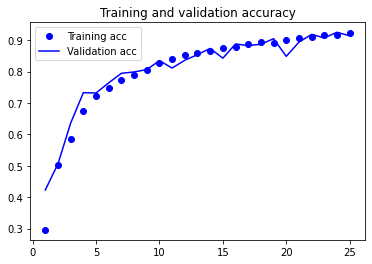

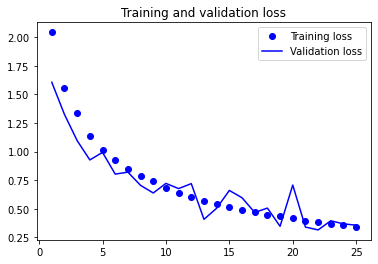

In [7]:
# Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [8]:
history2 = model.fit_generator(train_generator,
                              steps_per_epoch = 17943//64,
                              validation_data = val_generator,
                              validation_steps = 4481//64,
                              epochs = 25,
                              verbose = 1)

Epoch 1/25
280/280 [==============================] - 147s 524ms/step - loss: 0.3311 - accuracy: 0.9232 - val_loss: 0.3033 - val_accuracy: 0.9301
Epoch 2/25
280/280 [==============================] - 148s 530ms/step - loss: 0.3292 - accuracy: 0.9239 - val_loss: 0.3798 - val_accuracy: 0.9133
Epoch 3/25
280/280 [==============================] - 147s 526ms/step - loss: 0.3110 - accuracy: 0.9278 - val_loss: 0.3047 - val_accuracy: 0.9271
Epoch 4/25
280/280 [==============================] - 145s 518ms/step - loss: 0.3028 - accuracy: 0.9309 - val_loss: 0.2416 - val_accuracy: 0.9128
Epoch 5/25
280/280 [==============================] - 147s 523ms/step - loss: 0.2993 - accuracy: 0.9314 - val_loss: 0.2427 - val_accuracy: 0.9189
Epoch 6/25
280/280 [==============================] - 145s 517ms/step - loss: 0.2869 - accuracy: 0.9331 - val_loss: 0.3687 - val_accuracy: 0.9303
Epoch 7/25
280/280 [==============================] - 146s 523ms/step - loss: 0.2808 - accuracy: 0.9340 - val_loss: 0.2124 -

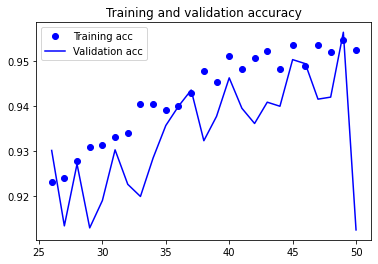

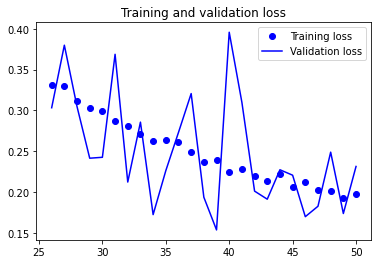

In [11]:
# Plot
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(26, len(acc) + 26)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [16]:
# initialize our own sequential model
model_v2 = Sequential()

# copy every layer except the predictions layer
for layer in vgg16_model.layers[:-1]:
  model_v2.add(layer)

# make weights fixed since these layers are already fine-tuned
for layer in model_v2.layers:
  layer.trainable = False

# add our own output layer
model_v2.add(Dense(10))
model_v2.add(Activation('softmax'))

model_v2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [0]:
model_v2.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
history_v2 = model_v2.fit_generator(train_generator,
                              steps_per_epoch = 17943//64,
                              validation_data = val_generator,
                              validation_steps = 4481//64,
                              epochs = 20,
                              verbose = 1)

Epoch 1/20
280/280 [==============================] - 145s 517ms/step - loss: 2.2390 - accuracy: 0.1846 - val_loss: 2.1187 - val_accuracy: 0.2882
Epoch 2/20
280/280 [==============================] - 147s 526ms/step - loss: 2.0922 - accuracy: 0.3142 - val_loss: 2.0262 - val_accuracy: 0.3607
Epoch 3/20
280/280 [==============================] - 147s 526ms/step - loss: 1.9787 - accuracy: 0.3851 - val_loss: 1.9792 - val_accuracy: 0.4621
Epoch 4/20
280/280 [==============================] - 145s 519ms/step - loss: 1.8802 - accuracy: 0.4436 - val_loss: 1.8677 - val_accuracy: 0.4677
Epoch 5/20
280/280 [==============================] - 145s 519ms/step - loss: 1.8007 - accuracy: 0.4751 - val_loss: 1.7309 - val_accuracy: 0.5114
Epoch 6/20
280/280 [==============================] - 146s 522ms/step - loss: 1.7300 - accuracy: 0.5032 - val_loss: 1.7183 - val_accuracy: 0.5164
Epoch 7/20
280/280 [==============================] - 146s 521ms/step - loss: 1.6650 - accuracy: 0.5321 - val_loss: 1.6864 -

In [19]:
history_v2_2 = model_v2.fit_generator(train_generator,
                              steps_per_epoch = 17943//64,
                              validation_data = val_generator,
                              validation_steps = 4481//64,
                              epochs = 20,
                              verbose = 1)

Epoch 1/20
280/280 [==============================] - 145s 516ms/step - loss: 1.1644 - accuracy: 0.7068 - val_loss: 1.0866 - val_accuracy: 0.7092
Epoch 2/20
280/280 [==============================] - 146s 521ms/step - loss: 1.1445 - accuracy: 0.7122 - val_loss: 1.1861 - val_accuracy: 0.7161
Epoch 3/20
280/280 [==============================] - 146s 521ms/step - loss: 1.1227 - accuracy: 0.7179 - val_loss: 0.9942 - val_accuracy: 0.7240
Epoch 4/20
280/280 [==============================] - 146s 522ms/step - loss: 1.1032 - accuracy: 0.7276 - val_loss: 1.0267 - val_accuracy: 0.7304
Epoch 5/20
280/280 [==============================] - 146s 522ms/step - loss: 1.0824 - accuracy: 0.7326 - val_loss: 1.0293 - val_accuracy: 0.7408
Epoch 6/20
280/280 [==============================] - 145s 518ms/step - loss: 1.0654 - accuracy: 0.7359 - val_loss: 0.8548 - val_accuracy: 0.7403
Epoch 7/20
280/280 [==============================] - 145s 518ms/step - loss: 1.0448 - accuracy: 0.7438 - val_loss: 1.0166 -

In [20]:
history_v2_3 = model_v2.fit_generator(train_generator,
                              steps_per_epoch = 17943//64,
                              validation_data = val_generator,
                              validation_steps = 4481//64,
                              epochs = 160,
                              verbose = 1)

Epoch 1/160
280/280 [==============================] - 145s 517ms/step - loss: 0.8465 - accuracy: 0.8053 - val_loss: 0.8793 - val_accuracy: 0.7993
Epoch 2/160
280/280 [==============================] - 145s 520ms/step - loss: 0.8326 - accuracy: 0.8097 - val_loss: 0.9626 - val_accuracy: 0.8067
Epoch 3/160
280/280 [==============================] - 145s 517ms/step - loss: 0.8251 - accuracy: 0.8087 - val_loss: 0.7876 - val_accuracy: 0.8030
Epoch 4/160
280/280 [==============================] - 145s 517ms/step - loss: 0.8153 - accuracy: 0.8119 - val_loss: 0.9567 - val_accuracy: 0.8114
Epoch 5/160
280/280 [==============================] - 145s 516ms/step - loss: 0.8015 - accuracy: 0.8181 - val_loss: 0.8674 - val_accuracy: 0.8144
Epoch 6/160
280/280 [==============================] - 145s 518ms/step - loss: 0.7914 - accuracy: 0.8209 - val_loss: 0.7639 - val_accuracy: 0.8153
Epoch 7/160
280/280 [==============================] - 145s 518ms/step - loss: 0.7832 - accuracy: 0.8239 - val_loss: 0

KeyboardInterrupt: ignored